In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline
import math
from IPython.display import display
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.datasets import make_imbalance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version',sns.__version__)

Numpy version 1.19.2
Pandas version 1.3.5
Seaborn version 0.10.1


In [2]:
# Heart Failure Prediction dataset
df_heart = pd.read_csv('heart.csv')

In [3]:
# to display all columns in the dataset
pd.options.display.max_columns = None

In [4]:
# Function to detect missing values and duplicate records

def missing_duplicates(col):
    if col.isnull().sum().sum() == 0:
        print('There are no missing values in the dataset')
    else:
        print('There are missing values in the dataset')
        
    count = 0
    for count in col.columns:
        if col[count].isnull().sum() != 0:
            print('There are {} missing values in the feature: '.format(col[count].isnull().sum()),count)
            print('Percentage of missing values in the feature:',round(col[count].isnull().sum()/col.shape[0] * 100,3),'%')
            print('Percentage of missing values in total data points:',round(col[count].isnull().sum()/(col.shape[0]*col.shape[1]) * 100,3),'%')
            
    if col.duplicated().sum() == 0:
        print('There are no duplicate records found in the dataset')
    else:
        print('There are duplicate rows found in the dataset.','\nTotal duplicate rows:', col.duplicated.sum())

In [5]:
# Function to check balance of the target variable and countplot
def balance_ratio(col):
    print('Balance ratio of variable in Percentage')
    print(round(col.value_counts(normalize=True) * 100,2))
    print('')
    sns.countplot(col)
    plt.title('Count plot')
    plt.show()

In [6]:
# Fuctions to plot the graphs for countplot, histograms and boxplot

# Function to plot the graph of countplots
def countplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(include=['object'])
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype == 'object':
            plt.subplot(a,b,c)
            sns.countplot(x=col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of Histograms
def histogram(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.distplot(col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of boxplots
def boxplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.boxplot(col[i])
            c = c + 1
    plt.show()
    return

In [7]:
# Function to create data imbalance
def create_imbalance(df,target_index,Perc):
    data = df.copy()
    
    # seperating independent and dependent variables
    X = data.drop(data.columns[target_index],axis=1)
    y = data.iloc[:,target_index]
    
    # creating imbalance from given percentage
    ratio1 = int(y.value_counts().sort_values(ascending=False)[0] * (Perc/100))
    ratio2 = int(y.value_counts().sort_values(ascending=False)[0]) - ratio1
    label1 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[0]
    label2 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[1]
    
    #making imbalance
    X_res, y_res = make_imbalance(X, y, sampling_strategy={label1:ratio1, label2:ratio2}, random_state=1)
    target_variable = data.columns[target_index]
    X_res[target_variable] = y_res
    
    return X_res

# Heart Failure Prediction dataset

In [8]:
# now lets exlore the heart failure dataset

# checking the top 5 rows of the data
df_heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [9]:
# information of the data
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
# describing the data
df_heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [11]:
# Checking missing values and duplicates
missing_duplicates(df_heart)

There are no missing values in the dataset
There are no duplicate records found in the dataset


In [12]:
df_heart['HeartDisease'] = np.where(df_heart['HeartDisease'] == 0,'No','Yes')

Balance ratio of variable in Percentage
Yes    55.34
No     44.66
Name: HeartDisease, dtype: float64



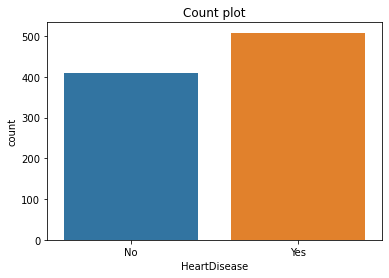

In [13]:
# Checking the target feature balance
balance_ratio(df_heart['HeartDisease'])

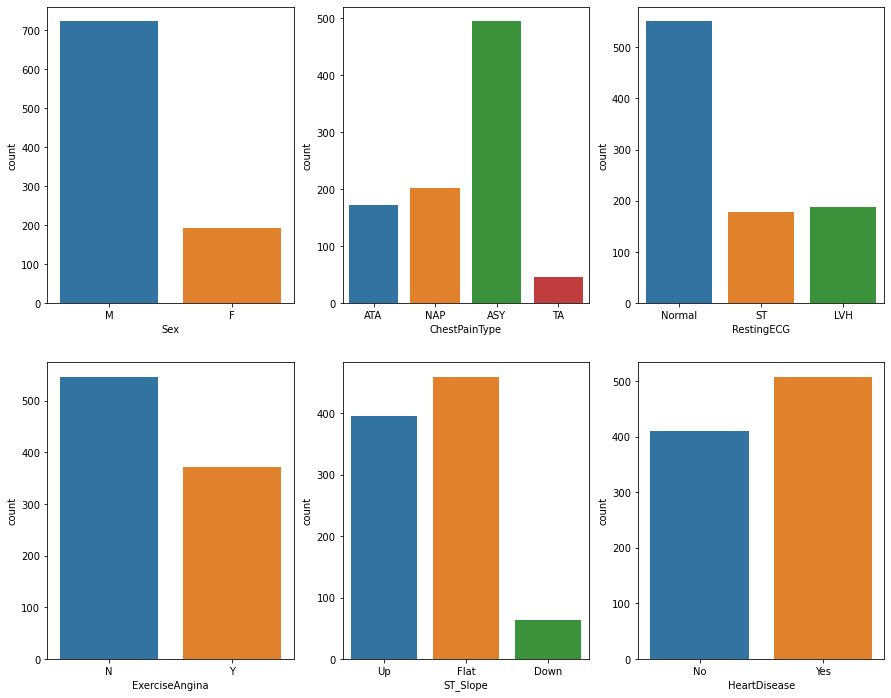

In [14]:
# we will check countplots for categorical variables
countplots(df_heart,15,12,3)

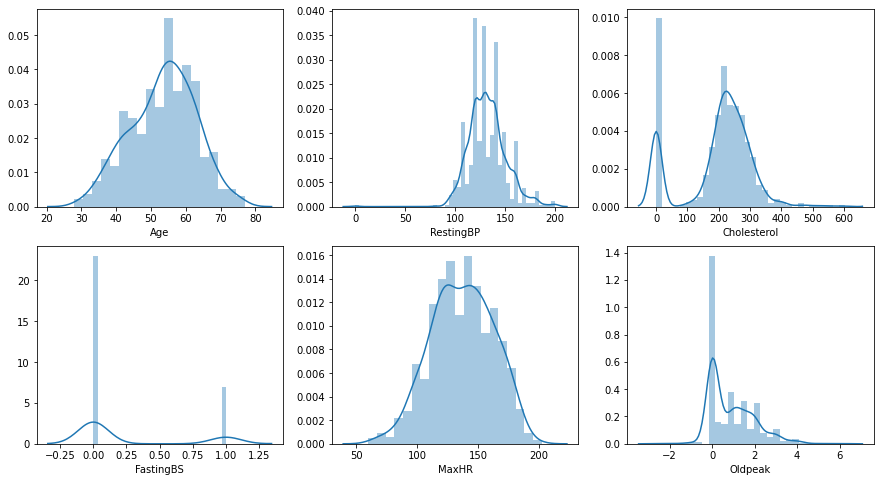

In [15]:
histogram(df_heart,15,8,3)

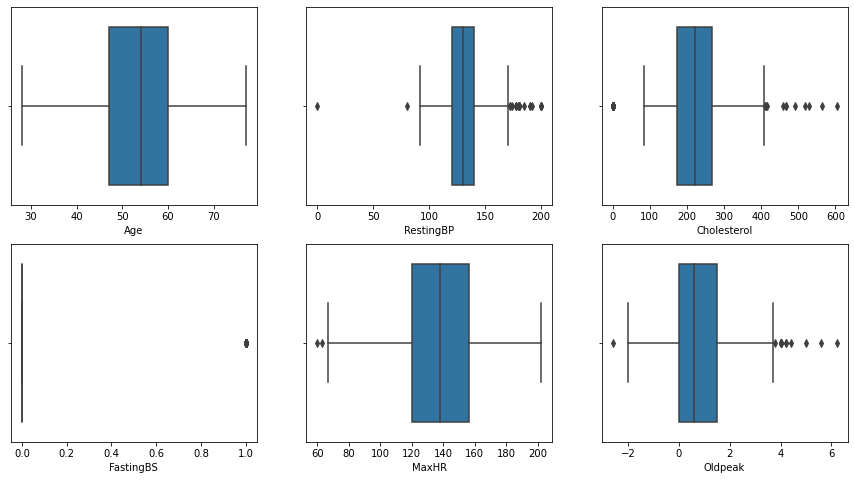

In [16]:
boxplots(df_heart,15,8,3)

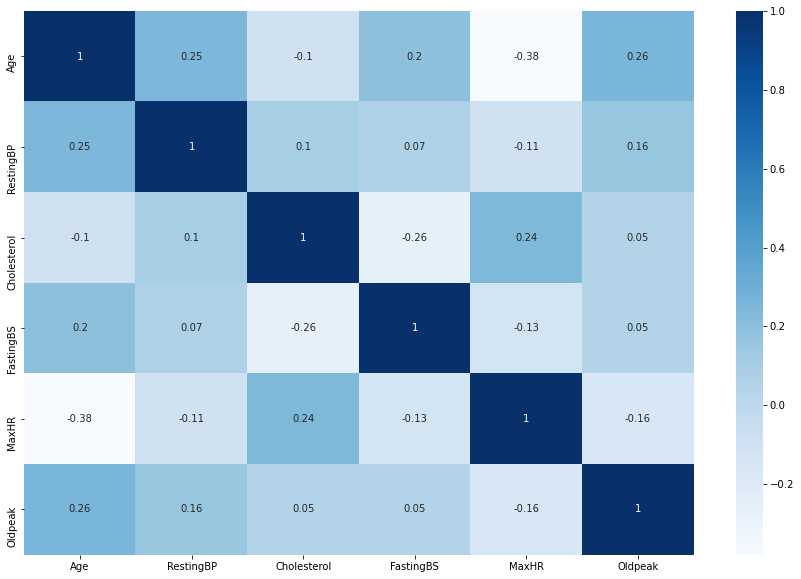

In [17]:
#Bivariate Analysis using heatmap
plt.figure(figsize=(15,10))
sns.heatmap(round(df_heart.corr(),2),annot=True,cmap='Blues')
plt.show()

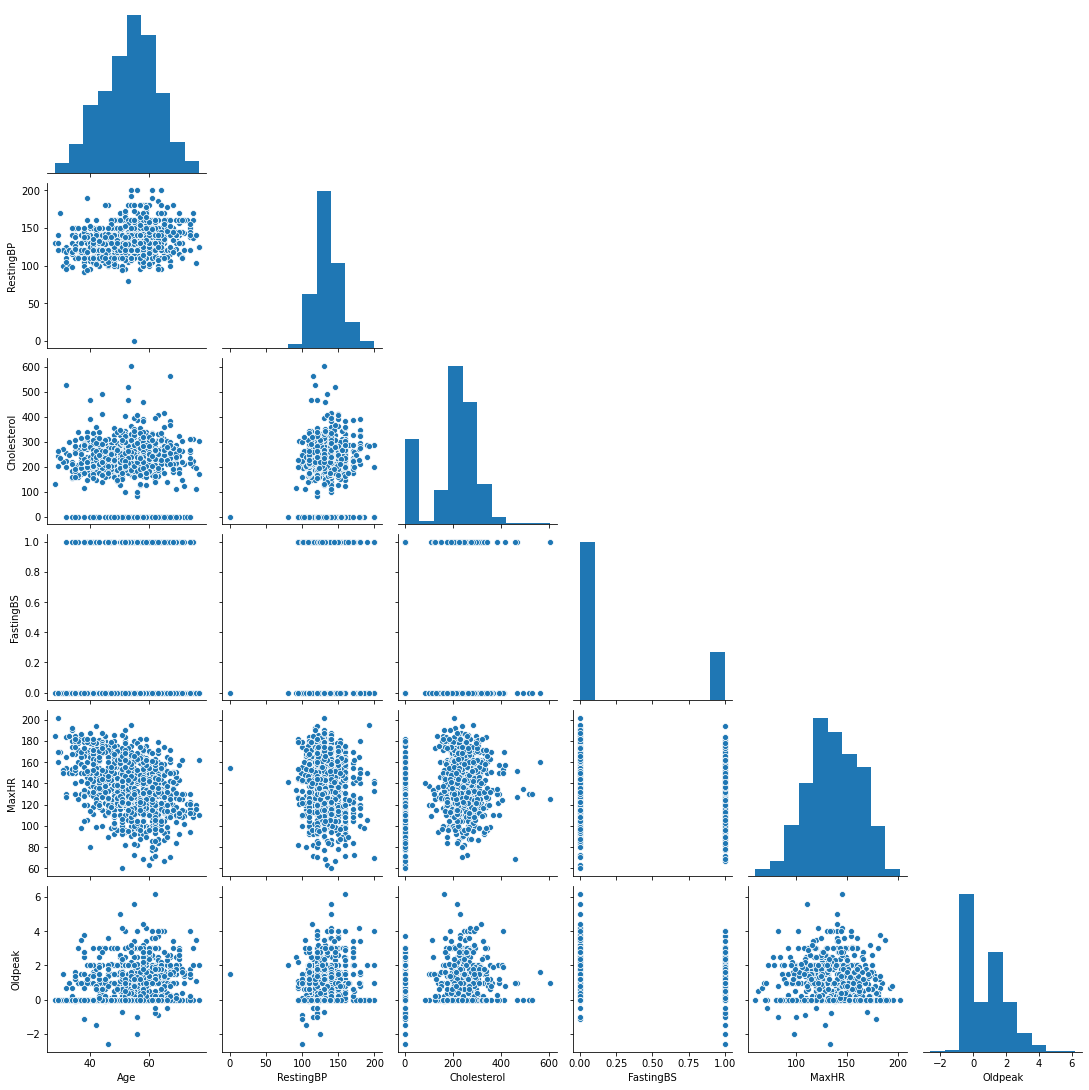

In [18]:
# pairplot
sns.pairplot(df_heart, corner=True)

In [19]:
df_heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [20]:
# We will perform one hot encoding on all categorical variables.
# Drop_first is set to True in order to avoid multicolinearity and also it reduces number of features
# We will not encode the target variable i.e 'HeartDisease'
df_heart = pd.get_dummies(data=df_heart, columns=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], drop_first=True)
df_heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,No,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,Yes,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,No,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,Yes,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,No,1,0,1,0,1,0,0,0,1


Balance ratio of variable in Percentage
Yes    64.96
No     35.04
Name: HeartDisease, dtype: float64



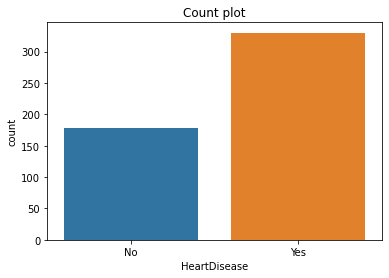

In [21]:
# creating 65:35 imbalance ratio
df_heart_65 = create_imbalance(df_heart,6,65)
balance_ratio(df_heart_65['HeartDisease'])

Balance ratio of variable in Percentage
Yes    75.0
No     25.0
Name: HeartDisease, dtype: float64



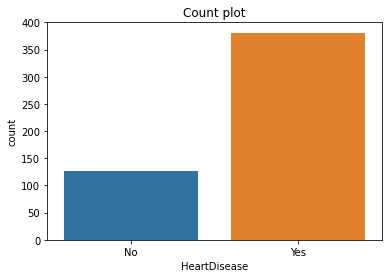

In [22]:
# creating 75:25 imbalance ratio
df_heart_75 = create_imbalance(df_heart,6,75)
balance_ratio(df_heart_75['HeartDisease'])

Balance ratio of variable in Percentage
Yes    89.96
No     10.04
Name: HeartDisease, dtype: float64



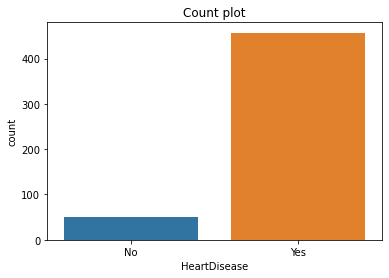

In [23]:
# creating 90:10 imbalance ratio
df_heart_90 = create_imbalance(df_heart,6,90)
balance_ratio(df_heart_90['HeartDisease'])

In [24]:
# seperating target and features
X = df_heart_90.drop(columns=['HeartDisease'],axis=1)
y = df_heart_90['HeartDisease']
print(X.shape)
print(y.shape)

(508, 15)
(508,)


In [25]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1, stratify=y)

In [26]:
# checking the shape after spliting
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(355, 15)
(153, 15)
(355,)
(153,)


In [27]:
# checking the distribution after spliting
y_train.value_counts(normalize=True)

Yes    0.898592
No     0.101408
Name: HeartDisease, dtype: float64

In [28]:
# checking the distribution after spliting
y_test.value_counts(normalize=True)

Yes    0.901961
No     0.098039
Name: HeartDisease, dtype: float64

In [29]:
# training default model just to see performance measures like confusion matrix and ROC AUC curve 
model = RandomForestClassifier()
parameters = {'n_estimators':[100]}
grid = GridSearchCV(model, param_grid=parameters, cv=5)
test = grid.fit(X_train, y_train)

In [30]:
#checking train score
test.score(X_train, y_train)

1.0

In [31]:
#checking test score
test.score(X_test, y_test)

0.9477124183006536

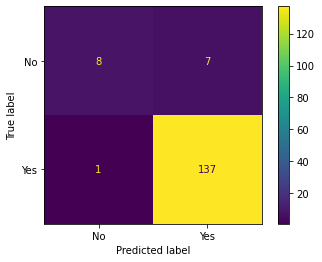

In [32]:
# checking confusion matrix for test data
metrics.plot_confusion_matrix(test,X_test,y_test)
plt.show()

AUC for the Training Data: 1.000
AUC for the Test Data: 0.955


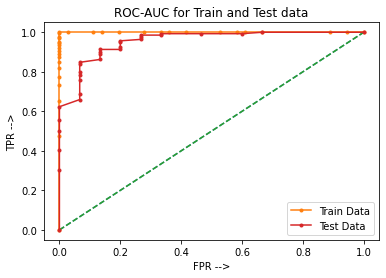

In [33]:
# Training Data Probability Prediction
pred_prob_train_RF_T = test.predict_proba(X_train)
pred_prob_test_RF_T = test.predict_proba(X_test)

#AUC & ROC for Train Data
auc = metrics.roc_auc_score(y_train,pred_prob_train_RF_T[:,1])
print('AUC for the Training Data: %.3f' % auc)
fpr, tpr, thresholds = metrics.roc_curve(y_train,pred_prob_train_RF_T[:,1],pos_label = ['Yes'])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.',label = 'Train Data')

#AUC & ROC for Test Data
auc = metrics.roc_auc_score(y_test,pred_prob_test_RF_T[:,1])
print('AUC for the Test Data: %.3f' % auc)
fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_prob_test_RF_T[:,1],pos_label = ['Yes'])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.',label='Test Data')

plt.legend(loc='best')
plt.xlabel('FPR -->')
plt.ylabel('TPR -->')
plt.title('ROC-AUC for Train and Test data')
plt.show()